# Load Packages

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data processing
from sklearn.model_selection import train_test_split

# Models
# LightGBM is a gradient boosting framework that uses tree based learning algorithms
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    true_positive_rate, false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Helper Functions

In [2]:
def split(sensitive_feature, str_sensitive_feature):
    # Train-test split
    df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    d.drop(columns=['race', 'action_taken', 'ethnicity', 'gender', 'age']), 
    Y, 
    sensitive_feature, 
    str_sensitive_feature,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)
    return df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test


def get_fairness_unaware_model(df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test):
    global unmitigated_model, test_scores, test_preds
    # unmitigated_model = test_scores = test_preds = None
    lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
    }
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(df_train, Y_train)
    print(model)
    unmitigated_model = model
    # Scores on test set
    test_scores = model.predict_proba(df_test)[:, 1]
    test_scores = test_scores
    print("Test Scores: ", test_scores)
    # Train AUC
    print( "AUC: ", roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1]))
    # Predictions (0 or 1) on test set
    test_preds = (test_scores >= np.mean(Y_train)) * 1
    # LightGBM feature importance 
    lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=15) 
    plt.show()
    # We next use Fairlearn's `MetricFrame` to examine the the two different kinds of errors (false positives and false negatives) on the test data.
    mf = MetricFrame({
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    Y_test, test_preds, sensitive_features=A_str_test)
    print(mf.by_group)
    # We calculate several performance and fairness metrics below:
    # Metrics
    models_dict = {"Unmitigated": (test_preds, test_scores)}
    print()
    print(get_metrics_df(models_dict, Y_test, A_str_test))
    
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        # defined by team6 - equal opportunity - the percentage of people that have rightfully benefitted from the loan model
        "True positive rate": (
            lambda x: true_positive_rate(y_true, x), True),
        # defined by team6 - equalized odds - the percentage of people that have wrongfully benefitted from the loan model
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        # defined by UCI Ex - 0 means that all groups have the same true positive, true negative, false positive, and false negative rates.)
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

def get_thresholdOptimizer_model(model, test_preds_, test_scores_, A_train, A_test, A_str_test):
    # global TO, postprocess_est, postprocess_preds, df_train_balanced, Y_train_balanced, A_train_balanced, test_scores, test_preds, models_dict
    global TO, postprocess_est, postprocess_preds, test_scores, test_preds, models_dict

    # TO = postprocess_est = postprocess_preds = df_train_balanced = Y_train_balanced = A_train_balanced= test_scores = test_preds = None

    test_scores_ = test_scores
    test_preds_ = test_preds
    postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    prefit=True)
    # Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
    # as there are points in the minority class (Y=1)
    balanced_idx1 = df_train[Y_train==1].index
    pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234, replace=True).index)
    df_train_balanced = df_train.loc[pp_train_idx, :]
    Y_train_balanced = Y_train.loc[pp_train_idx]
    A_train_balanced = A_train.loc[pp_train_idx]
    # save the parameters
    postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)
    TO = postprocess_est
    postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)
    
    postprocess_preds = postprocess_preds
    models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
    models_dict = models_dict
    print(get_metrics_df(models_dict, Y_test, A_str_test))
    return df_train_balanced, Y_train_balanced, A_train_balanced
    
def get_gridSearch_model(model, postprocess_preds, test_scores, test_preds, models_dict, A_str_test, df_train_balanced, Y_train_balanced, A_train_balanced):
    global GS_models, GS_metrics
    # GS_models = GS_metrics = None
    # Train GridSearch
    sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=1000,
                   grid_limit=10)

    sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)
    sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
    sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_]
    equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
    ]
    balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
    auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]
    # Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
    all_results = pd.DataFrame(
        {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
    ) 
    non_dominated = []
    models = []
    for row in all_results.itertuples(): 
        accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
        if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
            models.append(row)
            non_dominated.append(True)
        else:
            non_dominated.append(False)
    GS_models = models
    equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
    balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
    auc_non_dominated = np.asarray(auc_sweep)[non_dominated]
    # Plot equalized odds difference vs balanced accuracy
    plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
    plt.scatter(balanced_accuracy_score(Y_test, test_preds),
                equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
                label="Unmitigated Model")
    plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
                equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
                label="ThresholdOptimizer Model")
    plt.xlabel("Balanced Accuracy")
    plt.ylabel("Equalized Odds Difference")
    plt.legend(bbox_to_anchor=(1.55, 1))
    plt.show()
    # As intended, GridSearch models appear along the trade-off curve between the large balanced accuracy (but also large disparity), and low disparity (but worse balanced accuracy). This gives the data scientist a flexibility to select a model that fits the application context best.
    # Plot equalized odds difference vs AUC
    plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
    plt.scatter(roc_auc_score(Y_test, test_scores),
                equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
                label="Unmitigated Model")
    plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
                equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
                label="ThresholdOptimizer Model")
    plt.xlabel("AUC")
    plt.ylabel("Equalized Odds Difference")
    plt.legend(bbox_to_anchor=(1.55, 1))
    plt.show()
    # Similarly, GridSearch models appear along the trade-off curve between AUC and equalized odds difference.
    # Compare GridSearch models with low values of equalized odds difference with the previously constructed models
    grid_search_dict = {"GridSearch_{}".format(i): (sweep_preds[i], sweep_scores[i])
                        for i in range(len(sweep_preds))
                        if non_dominated[i] and equalized_odds_sweep[i]<0.1}
    models_dict.update(grid_search_dict)
    GS_metrics = models_dict
    print(get_metrics_df(models_dict, Y_test, A_str_test))


# Race - DC

In [3]:
# load the clean data
d = 'data/Fairlearn_DC.csv'
d = pd.read_csv(d, sep = ',')
d.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,0,1,0,1,1,2,2,3,3,1,1
1,0,1,1,1,0,3,3,2,2,4,3,3,1
2,0,2,0,1,0,1,3,2,2,4,2,3,3
3,0,1,0,1,0,1,3,2,2,2,3,5,1
4,0,3,0,1,0,1,1,2,2,4,3,2,1


In [4]:
# Extract the sensitive feature - example: race
A = d["race"].apply(lambda x:1 if x == 1 else 0)
A_str = A.map({ 1:"White", 0:"Non-White"})
A_str

0            White
1            White
2        Non-White
3            White
4        Non-White
           ...    
89150    Non-White
89151        White
89152        White
89153    Non-White
89154        White
Name: race, Length: 89155, dtype: object

In [5]:
# Extract the target
Y = d["action_taken"]
categorical_features = ['preapproval_requested', 'loan_type','loan_purpose', 'interest_only_payment', 'balloon_payment', 'debt_to_income_ratio', 'income']
for col in categorical_features:
    d[col] = d[col].astype('category')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89155 entries, 0 to 89154
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ethnicity              89155 non-null  int64   
 1   race                   89155 non-null  int64   
 2   gender                 89155 non-null  int64   
 3   action_taken           89155 non-null  int64   
 4   preapproval_requested  89155 non-null  category
 5   loan_type              89155 non-null  category
 6   loan_purpose           89155 non-null  category
 7   interest_only_payment  89155 non-null  category
 8   balloon_payment        89155 non-null  category
 9   debt_to_income_ratio   89155 non-null  category
 10  age                    89155 non-null  int64   
 11  income                 89155 non-null  category
 12  loan_to_value_ratio    89155 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 4.7 MB


In [6]:
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = split(A, A_str)

In [7]:
len(df_test)

26747

In [8]:
len(Y_test)

26747

In [9]:
A_str_test

64779        White
43317    Non-White
59928        White
78066    Non-White
52771    Non-White
           ...    
61050        White
4228         White
57226    Non-White
56322        White
3894         White
Name: race, Length: 26747, dtype: object

## Using a Fairness Unaware Model

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')
Test Scores:  [0.93011649 0.83824133 0.92549781 ... 0.9124246  0.93011649 0.83824133]
AUC:  0.8444153179566672


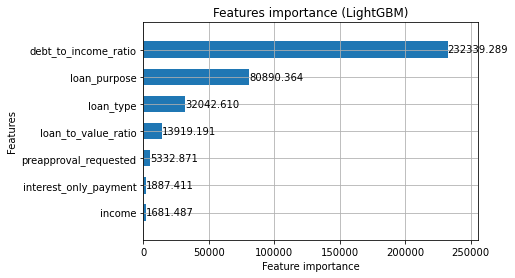

                FPR       FNR
race                         
Non-White   0.33186  0.146432
White      0.317308  0.139082

                               Unmitigated
Overall selection rate            0.732082
Demographic parity difference     0.065589
Demographic parity ratio          0.913861
------                                    
Overall balanced error rate       0.766138
Balanced error rate difference    0.010951
 ------                                   
True positive rate                0.857912
False positive rate difference    0.014552
False negative rate difference     0.00735
Equalized odds difference         0.014552
  ------                                  
Overall AUC                       0.840792
AUC difference                    0.007402


In [10]:
get_fairness_unaware_model(df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test)

In [11]:
unmitigated_DC_race = unmitigated_model
print(unmitigated_DC_race)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')


In [12]:
dc_race_test_scores = unmitigated_DC_race.predict_proba(df_test)[:, 1]

In [13]:
dc_race_test_preds = (dc_race_test_scores >= np.mean(Y_train)) * 1

In [14]:
dc_race_test_preds = pd.DataFrame(dc_race_test_preds)

In [15]:
A_str_test.reset_index(drop= True, inplace= True)

In [16]:
unmigigated_pred_mid_race = pd.concat([dc_race_test_preds , A_str_test], axis="columns")
unmigigated_pred_mid_race

,0,race
0,1,White
1,1,Non-White
2,1,White
3,1,Non-White
4,1,Non-White
...,...,...
26742,0,White
26743,1,White
26744,1,Non-White
26745,1,White


In [17]:
unmigigated_pred_mid_race.to_excel(r'dc_unmitigated_pred_race.xlsx', index=False)

## Mitigating Equalized Odds Difference with Postprocessing

We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [18]:
df_train_balanced_race_DC, Y_train_balanced_race_DC, A_train_balanced_race_DC = get_thresholdOptimizer_model(unmitigated_DC_race, test_preds, test_scores, A_train, A_test, A_str_test)

                               Unmitigated ThresholdOptimizer
Overall selection rate            0.732082           0.877444
Demographic parity difference     0.065589           0.050941
Demographic parity ratio          0.913861           0.943414
------                                                       
Overall balanced error rate       0.766138           0.706812
Balanced error rate difference    0.010951           0.002089
 ------                                                      
True positive rate                0.857912           0.975225
False positive rate difference    0.014552           0.004802
False negative rate difference     0.00735           0.000624
Equalized odds difference         0.014552           0.004802
  ------                                                     
Overall AUC                       0.840792           0.706812
AUC difference                    0.007402           0.002089


In [19]:
ThresholdOptimizer_DC_race = TO
print(ThresholdOptimizer_DC_race)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LGBMClassifier(learning_rate=0.03, max_depth=3,
                                            metric='auc', num_leaves=10,
                                            objective='binary'),
                   prefit=True)


The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


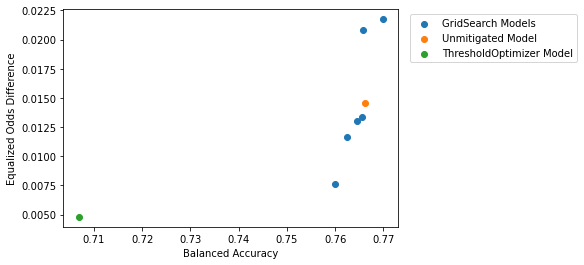

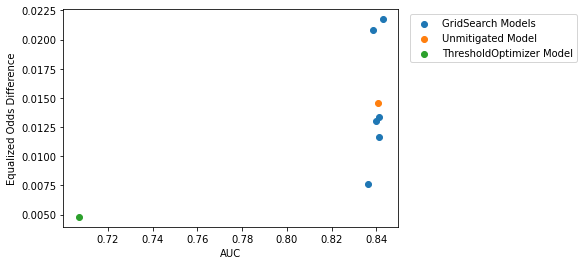

                               Unmitigated ThresholdOptimizer GridSearch_421  \
Overall selection rate            0.732082           0.877444       0.728269   
Demographic parity difference     0.065589           0.050941       0.071388   
Demographic parity ratio          0.913861           0.943414       0.906096   
------                                                                         
Overall balanced error rate       0.766138           0.706812       0.764573   
Balanced error rate difference    0.010951           0.002089       0.009633   
 ------                                                                        
True positive rate                0.857912           0.975225       0.853359   
False positive rate difference    0.014552           0.004802        0.00625   
False negative rate difference     0.00735           0.000624       0.013016   
Equalized odds difference         0.014552           0.004802       0.013016   
  ------                                

In [20]:
get_gridSearch_model(unmitigated_DC_race, postprocess_preds, test_scores, test_preds, models_dict, A_str_test, df_train_balanced_race_DC, Y_train_balanced_race_DC, A_train_balanced_race_DC)

In [21]:
GS_race_DC_models = GS_models
print(GS_race_DC_models)
print()
GS_race_DC_metrics = GS_metrics
print(GS_race_DC_metrics)

[Pandas(Index=421, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7645728018173507, disparity=0.01301553704592373), Pandas(Index=505, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7699056221917894, disparity=0.02174215244928901), Pandas(Index=506, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7655806269726121, disparity=0.013344777154106147), Pandas(Index=548, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7658779416462719, disparity=0.02081500460836505), Pandas(Index=549, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7625097846576196, disparity=0.01161716

In [23]:
# chose the model with AUC = 85.98% from grid search
test_pred_gird_search_421 = GS_race_DC_metrics.get("GridSearch_421")[0]

In [24]:
test_pred_gird_search_421_series = pd.Series(test_pred_gird_search_421)
test_pred_gird_search_421_series.reset_index(drop=True, inplace=True)

In [25]:
A_str_test.reset_index(drop= True, inplace= True)

In [26]:
test_preds

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
migigated_pred_mid_race = pd.concat([test_pred_gird_search_421_series , A_str_test], axis="columns")

In [28]:
migigated_pred_mid_race

,0,race
0,1,White
1,1,Non-White
2,1,White
3,1,Non-White
4,1,Non-White
...,...,...
26742,0,White
26743,1,White
26744,1,Non-White
26745,1,White


In [29]:
migigated_pred_mid_race.to_excel(r'dc_mitigated_pred_race.xlsx', index=False)

## Conclusion

In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.

# Age - DC

In [30]:
# load the clean data
d = 'data/Fairlearn_DC.csv'
d = pd.read_csv(d, sep = ',')
d.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,0,1,0,1,1,2,2,3,3,1,1
1,0,1,1,1,0,3,3,2,2,4,3,3,1
2,0,2,0,1,0,1,3,2,2,4,2,3,3
3,0,1,0,1,0,1,3,2,2,2,3,5,1
4,0,3,0,1,0,1,1,2,2,4,3,2,1


In [31]:
# Extract the sensitive feature - example: age - middle-aged vs non m-a
B = d["age"].apply(lambda x:1 if x == 2 else 0)
B_str = B.map({ 1:"Middle-Aged", 0:"Non-Middle-Aged"})
B_str

0        Non-Middle-Aged
1        Non-Middle-Aged
2            Middle-Aged
3        Non-Middle-Aged
4        Non-Middle-Aged
              ...       
89150    Non-Middle-Aged
89151    Non-Middle-Aged
89152        Middle-Aged
89153    Non-Middle-Aged
89154    Non-Middle-Aged
Name: age, Length: 89155, dtype: object

In [32]:
# Extract the target
Y = d["action_taken"]
categorical_features = ['preapproval_requested', 'loan_type','loan_purpose', 'interest_only_payment', 'balloon_payment', 'debt_to_income_ratio', 'income']
for col in categorical_features:
    d[col] = d[col].astype('category')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89155 entries, 0 to 89154
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ethnicity              89155 non-null  int64   
 1   race                   89155 non-null  int64   
 2   gender                 89155 non-null  int64   
 3   action_taken           89155 non-null  int64   
 4   preapproval_requested  89155 non-null  category
 5   loan_type              89155 non-null  category
 6   loan_purpose           89155 non-null  category
 7   interest_only_payment  89155 non-null  category
 8   balloon_payment        89155 non-null  category
 9   debt_to_income_ratio   89155 non-null  category
 10  age                    89155 non-null  int64   
 11  income                 89155 non-null  category
 12  loan_to_value_ratio    89155 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 4.7 MB


In [33]:
df_train, df_test, Y_train, Y_test, B_train, B_test, B_str_train, B_str_test = split(B, B_str)

## Using a Fairness Unaware Model

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')
Test Scores:  [0.93011649 0.83824133 0.92549781 ... 0.9124246  0.93011649 0.83824133]
AUC:  0.8444153179566672


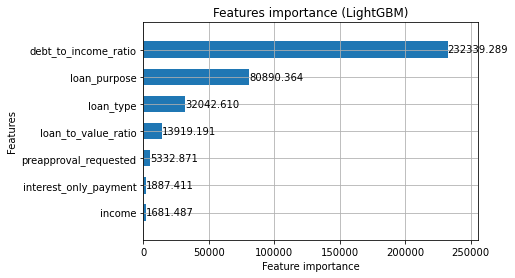

                      FPR       FNR
age                                
Middle-Aged      0.335514  0.143542
Non-Middle-Aged  0.315451  0.140507

                               Unmitigated
Overall selection rate            0.732082
Demographic parity difference     0.007506
Demographic parity ratio          0.989798
------                                    
Overall balanced error rate       0.766138
Balanced error rate difference    0.011549
 ------                                   
True positive rate                0.857912
False positive rate difference    0.020063
False negative rate difference    0.003035
Equalized odds difference         0.020063
  ------                                  
Overall AUC                       0.840792
AUC difference                    0.019052


In [34]:
get_fairness_unaware_model(df_train, df_test, Y_train, Y_test, B_train, B_test, B_str_train, B_str_test)

In [35]:
unmitigated_DC_age = unmitigated_model
print(unmitigated_DC_age)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')


In [36]:
dc_age_test_scores = unmitigated_DC_age.predict_proba(df_test)[:, 1]
dc_age_test_preds = (dc_age_test_scores >= np.mean(Y_train)) * 1
dc_age_test_preds = pd.DataFrame(dc_age_test_preds)
B_str_test.reset_index(drop= True, inplace= True)
unmigigated_pred_mid_age = pd.concat([dc_age_test_preds , B_str_test], axis="columns")
unmigigated_pred_mid_age

,0,age
0,1,Middle-Aged
1,1,Middle-Aged
2,1,Non-Middle-Aged
3,1,Middle-Aged
4,1,Middle-Aged
...,...,...
26742,0,Middle-Aged
26743,1,Non-Middle-Aged
26744,1,Middle-Aged
26745,1,Middle-Aged


In [37]:
unmigigated_pred_mid_race.to_excel(r'dc_unmitigated_pred_age.xlsx', index=False)

## Mitigating Equalized Odds Difference with Postprocessing
We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [38]:
#get_thresholdOptimizer_model(unmitigated_DC_age, test_preds, test_scores, B_train, B_test, B_str_test)
df_train_balanced_age_DC, Y_train_balanced_age_DC, A_train_balanced_age_DC = get_thresholdOptimizer_model(unmitigated_DC_age, test_preds, test_scores, B_train, B_test, B_str_test)

print()
ThresholdOptimizer_DC_age = TO
print(ThresholdOptimizer_DC_age)

                               Unmitigated ThresholdOptimizer
Overall selection rate            0.732082            0.88952
Demographic parity difference     0.007506            0.00106
Demographic parity ratio          0.989798           0.998809
------                                                       
Overall balanced error rate       0.766138           0.690591
Balanced error rate difference    0.011549            0.01683
 ------                                                      
True positive rate                0.857912           0.979632
False positive rate difference    0.020063           0.030388
False negative rate difference    0.003035           0.003272
Equalized odds difference         0.020063           0.030388
  ------                                                     
Overall AUC                       0.840792           0.690591
AUC difference                    0.019052            0.01683

ThresholdOptimizer(constraints='equalized_odds',
                   e

The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


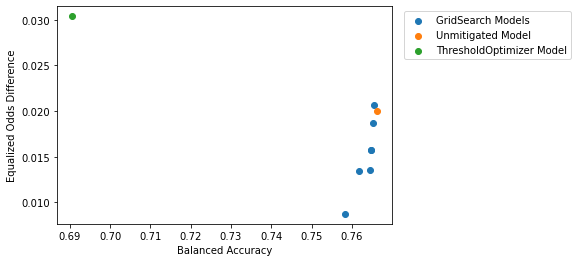

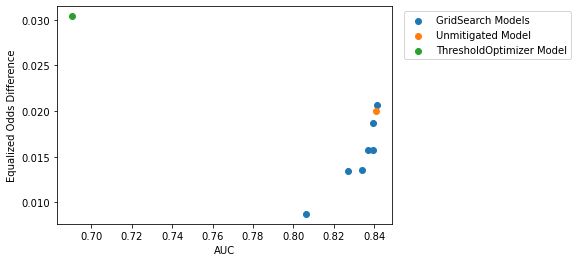

                               Unmitigated ThresholdOptimizer GridSearch_345  \
Overall selection rate            0.732082            0.88952        0.71608   
Demographic parity difference     0.007506            0.00106       0.000192   
Demographic parity ratio          0.989798           0.998809       0.999732   
------                                                                         
Overall balanced error rate       0.766138           0.690591       0.758249   
Balanced error rate difference    0.011549            0.01683       0.007661   
 ------                                                                        
True positive rate                0.857912           0.979632       0.838181   
False positive rate difference    0.020063           0.030388        0.00658   
False negative rate difference    0.003035           0.003272       0.008743   
Equalized odds difference         0.020063           0.030388       0.008743   
  ------                                

In [39]:
# df_train_balanced_race_DC, Y_train_balanced_race_DC, A_train_balanced_race_DC = get_thresholdOptimizer_model(unmitigated_DC_age, test_preds, test_scores, B_train, B_test, B_str_test)
get_gridSearch_model(unmitigated_DC_age, postprocess_preds, test_scores, test_preds, models_dict, B_str_test, df_train_balanced_age_DC, Y_train_balanced_age_DC, A_train_balanced_age_DC)
print()
GS_age_DC_models = GS_models
print(GS_age_DC_models)
print()
GS_age_DC_metrics = GS_metrics
print(GS_age_DC_metrics)

In [40]:
# chose the model with AUC = 85.98% from grid search
test_pred_gird_search_505 = GS_age_DC_metrics.get("GridSearch_505")[0]

In [41]:
test_pred_gird_search_505_series = pd.Series(test_pred_gird_search_505)
test_pred_gird_search_505_series.reset_index(drop=True, inplace=True)

In [42]:
test_pred_gird_search_505_series.sum()

19680

In [43]:
B_str_test.reset_index(drop= True, inplace= True)

In [44]:
test_preds

array([1, 1, 1, ..., 1, 1, 1])

In [45]:
migigated_pred_mid_age = pd.concat([test_pred_gird_search_505_series , B_str_test], axis="columns")

In [46]:
test_pred_gird_search_505_series

0        1
1        1
2        1
3        1
4        1
        ..
26742    0
26743    1
26744    1
26745    1
26746    1
Length: 26747, dtype: int32

In [47]:
migigated_pred_mid_age

,0,age
0,1,Middle-Aged
1,1,Middle-Aged
2,1,Non-Middle-Aged
3,1,Middle-Aged
4,1,Middle-Aged
...,...,...
26742,0,Middle-Aged
26743,1,Non-Middle-Aged
26744,1,Middle-Aged
26745,1,Middle-Aged


In [48]:
migigated_pred_mid_age.to_excel(r'dc_mitigated_pred_age.xlsx', index=False)

## Conclusion
In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.

# Ethinicity - DC

In [49]:
# load the clean data
d = 'data/Fairlearn_DC.csv'
d = pd.read_csv(d, sep = ',')
d.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,0,1,0,1,1,2,2,3,3,1,1
1,0,1,1,1,0,3,3,2,2,4,3,3,1
2,0,2,0,1,0,1,3,2,2,4,2,3,3
3,0,1,0,1,0,1,3,2,2,2,3,5,1
4,0,3,0,1,0,1,1,2,2,4,3,2,1


In [50]:
# Extract the sensitive feature - example: ethnicity - hispanic vs non hispanic
C = d["ethnicity"].apply(lambda x:1 if x == 0 else 0)
C_str = C.map({ 1:"Hispanic", 0:"Non-Hispanic"})
C_str

0            Hispanic
1            Hispanic
2            Hispanic
3            Hispanic
4            Hispanic
             ...     
89150        Hispanic
89151        Hispanic
89152    Non-Hispanic
89153        Hispanic
89154        Hispanic
Name: ethnicity, Length: 89155, dtype: object

In [51]:
# Extract the target
Y = d["action_taken"]
categorical_features = ['preapproval_requested', 'loan_type','loan_purpose', 'interest_only_payment', 'balloon_payment', 'debt_to_income_ratio', 'income']
for col in categorical_features:
    d[col] = d[col].astype('category')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89155 entries, 0 to 89154
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ethnicity              89155 non-null  int64   
 1   race                   89155 non-null  int64   
 2   gender                 89155 non-null  int64   
 3   action_taken           89155 non-null  int64   
 4   preapproval_requested  89155 non-null  category
 5   loan_type              89155 non-null  category
 6   loan_purpose           89155 non-null  category
 7   interest_only_payment  89155 non-null  category
 8   balloon_payment        89155 non-null  category
 9   debt_to_income_ratio   89155 non-null  category
 10  age                    89155 non-null  int64   
 11  income                 89155 non-null  category
 12  loan_to_value_ratio    89155 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 4.7 MB


In [52]:
df_train, df_test, Y_train, Y_test, C_train, C_test, C_str_train, C_str_test = split(C, C_str)

## Using a Fairness Unaware Model

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')
Test Scores:  [0.93011649 0.83824133 0.92549781 ... 0.9124246  0.93011649 0.83824133]
AUC:  0.8444153179566672


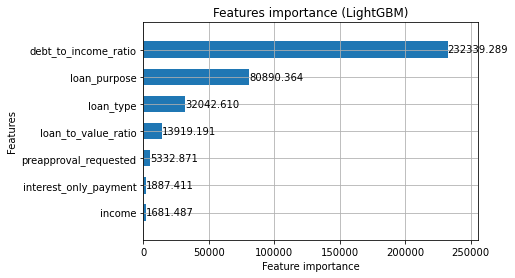

                   FPR       FNR
ethnicity                       
Hispanic      0.329435  0.145786
Non-Hispanic  0.298039  0.113353

                               Unmitigated
Overall selection rate            0.732082
Demographic parity difference     0.010211
Demographic parity ratio          0.986222
------                                    
Overall balanced error rate       0.766138
Balanced error rate difference    0.031914
 ------                                   
True positive rate                0.857912
False positive rate difference    0.031396
False negative rate difference    0.032433
Equalized odds difference         0.032433
  ------                                  
Overall AUC                       0.840792
AUC difference                      0.0269


In [53]:
get_fairness_unaware_model(df_train, df_test, Y_train, Y_test, C_train, C_test, C_str_train, C_str_test)

In [54]:
unmitigated_DC_ethinicity = unmitigated_model
print(unmitigated_DC_ethinicity)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')


In [55]:
dc_ethnicity_test_scores = unmitigated_DC_age.predict_proba(df_test)[:, 1]
dc_ethnicity_test_preds = (dc_ethnicity_test_scores >= np.mean(Y_train)) * 1
dc_ethnicity_test_preds = pd.DataFrame(dc_ethnicity_test_preds)
C_str_test.reset_index(drop= True, inplace= True)
unmigigated_pred_mid_ethnicity = pd.concat([dc_ethnicity_test_preds , C_str_test], axis="columns")
unmigigated_pred_mid_ethnicity

,0,ethnicity
0,1,Hispanic
1,1,Hispanic
2,1,Non-Hispanic
3,1,Hispanic
4,1,Hispanic
...,...,...
26742,0,Hispanic
26743,1,Hispanic
26744,1,Hispanic
26745,1,Hispanic


In [56]:
unmigigated_pred_mid_race.to_excel(r'dc_unmitigated_pred_ethnicity.xlsx', index=False)

## Mitigating Equalized Odds Difference with Postprocessing
We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [57]:
df_train_balanced_ethnicity_DC, Y_train_balanced_ethnicity_DC, A_train_balanced_ethinicity_DC = get_thresholdOptimizer_model(unmitigated_DC_ethinicity, test_preds, test_scores, C_train, C_test, C_str_test)
print()
ThresholdOptimizer_DC_ethinicity = TO
print(ThresholdOptimizer_DC_ethinicity)

                               Unmitigated ThresholdOptimizer
Overall selection rate            0.732082           0.879912
Demographic parity difference     0.010211           0.017707
Demographic parity ratio          0.986222           0.979924
------                                                       
Overall balanced error rate       0.766138           0.705736
Balanced error rate difference    0.031914           0.019972
 ------                                                      
True positive rate                0.857912           0.977184
False positive rate difference    0.031396           0.042784
False negative rate difference    0.032433            0.00284
Equalized odds difference         0.032433           0.042784
  ------                                                     
Overall AUC                       0.840792           0.705736
AUC difference                      0.0269           0.019972

ThresholdOptimizer(constraints='equalized_odds',
                   e

The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


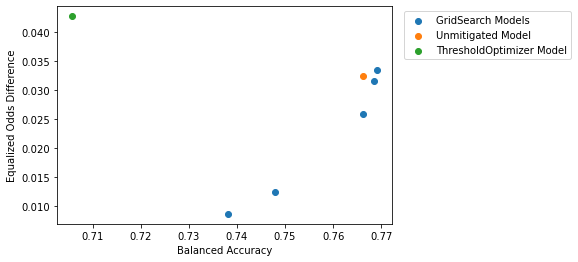

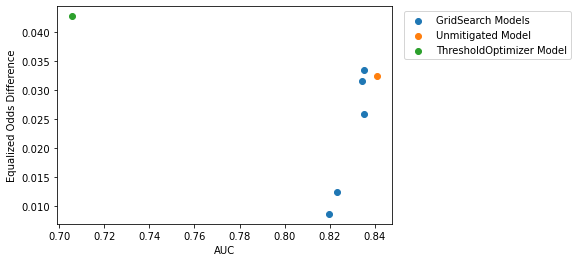

                               Unmitigated ThresholdOptimizer GridSearch_281  \
Overall selection rate            0.732082           0.879912       0.693237   
Demographic parity difference     0.010211           0.017707       0.017497   
Demographic parity ratio          0.986222           0.979924       0.974834   
------                                                                         
Overall balanced error rate       0.766138           0.705736       0.747951   
Balanced error rate difference    0.031914           0.019972       0.002003   
 ------                                                                        
True positive rate                0.857912           0.977184       0.810468   
False positive rate difference    0.031396           0.042784       0.008392   
False negative rate difference    0.032433            0.00284       0.012397   
Equalized odds difference         0.032433           0.042784       0.012397   
  ------                                

In [58]:
get_gridSearch_model(unmitigated_DC_ethinicity, postprocess_preds, test_scores, test_preds, models_dict, C_str_test, df_train_balanced_ethnicity_DC, Y_train_balanced_ethnicity_DC, A_train_balanced_ethinicity_DC)
print()
GS_ethinicity_DC_models = GS_models
print(GS_ethinicity_DC_models)
print()
GS_ethinicity_DC_metrics = GS_metrics
print(GS_ethinicity_DC_metrics)

In [59]:
# chose the model with AUC = 85.98% from grid search
test_pred_gird_search_346 = GS_ethinicity_DC_metrics.get("GridSearch_346")[0]

In [60]:
test_pred_gird_search_346_series = pd.Series(test_pred_gird_search_346)
test_pred_gird_search_346_series.reset_index(drop=True, inplace=True)

In [61]:
test_pred_gird_search_346_series.sum()

19317

In [62]:
C_str_test.reset_index(drop= True, inplace= True)

In [63]:
test_preds

array([1, 1, 1, ..., 1, 1, 1])

In [64]:
migigated_pred_mid_ethnicity = pd.concat([test_pred_gird_search_346_series , C_str_test], axis="columns")

In [65]:
test_pred_gird_search_346_series

0        1
1        1
2        1
3        1
4        1
        ..
26742    0
26743    1
26744    1
26745    1
26746    1
Length: 26747, dtype: int32

In [66]:
migigated_pred_mid_ethnicity

,0,ethnicity
0,1,Hispanic
1,1,Hispanic
2,1,Non-Hispanic
3,1,Hispanic
4,1,Hispanic
...,...,...
26742,0,Hispanic
26743,1,Hispanic
26744,1,Hispanic
26745,1,Hispanic


In [67]:
migigated_pred_mid_ethnicity.to_excel(r'dc_mitigated_pred_ethnicity.xlsx', index=False)

## Conclusion
In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.